# シフト最適化問題

シフト最適化問題とは、特定の条件や制約を満たしつつ、従業員のシフトを効率的に配置し、労働時間やコストを最小化する問題です。本チュートリアルでは、労働時間の最小化を目的としたシフト最適化問題をどのように解くかを説明します。

## 問題設定

以下では、複数の作業者に対して複数の仕事を割り当てた際の賃金の合計を最小化するシフト最適化問題を考えます。ただし、賃金は作業者毎に定められており、日給制であるとします。各仕事の開始時刻と終了時刻、各作業者の賃金が与えられたとき、以下の制約を満たしながら賃金の合計を最小化するにはどうすれば良いでしょうか？

- 各仕事は1人の作業者を必要とする。
- 作業者は同時に複数の仕事をすることができない。

具体例として、以下の画像のような場合を考えてみましょう。

![](./assets/shift_opt01.png)

この場合、仕事Aと仕事Bは作業時間が重なっていないので、1人の作業者がこれらの仕事を行えます。そのため、作業者は2人で十分であり、賃金の安い作業者から順に仕事を割り当てれば賃金の合計が300ドルで済むことがわかります。

## 事前準備

上記のようなシフト最適化問題の数理モデルを構築する前に、仕事の開始時刻と終了時刻のリストおよび作業時間が重なる仕事のリストを準備しましょう。

まずは、仕事の開始時刻と終了時刻のリストです。

In [1]:
from datetime import time
job_list = [
    (time(17, 0), time(18, 0)), # job 0
    (time(13, 0), time(14, 0)), # job 1
    (time(13, 30), time(14, 30)), # job 2
    (time(13, 40), time(14, 40)), # job 3
    (time(16, 40), time(17, 40)), # job 4
    (time(11, 40), time(13, 40)), # job 5
    (time(18, 40), time(19, 40)), # job 6
    (time(18, 40), time(19, 40)), # job 7
    (time(18, 00), time(19, 00)), # job 8
]

次に、作業時間が重なっている仕事を見つけるために、 `networkx` を利用して仕事の関係性を示すグラフを作りましょう。以下のコードで出来上がるグラフは、点 `i` が仕事 `job_list[i]` と対応しており、辺はその両端の点に対応する仕事の作業時間が重なっていることを示しています。

In [2]:
import networkx as nx

def has_overlap(t1start: time, t1end: time, t2start: time, t2end: time):
    return (t1start <= t2start <= t1end) or (t2start <= t1start <= t2end)

def gen_index_graph(time_list: list[tuple[time, time]]) -> nx.Graph:
    G = nx.Graph()
    for j in range(len(time_list)):
        for k in range(j + 1, len(time_list)):
            if has_overlap(
                time_list[j][0], time_list[j][1], time_list[k][0], time_list[k][1]
            ):
                G.add_edge(j, k)

    return G

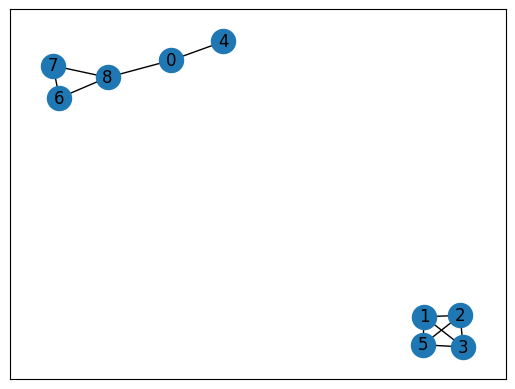

In [3]:
g = gen_index_graph(job_list)
nx.draw_networkx(g, with_labels=True)

このグラフからクリーク（clique）と呼ばれる部分グラフを見つけることで、作業時間が重なる仕事がわかります。 `networkx` には、このクリークを見つけるための関数 `find_cliques` が用意されているので、それを使ってクリークを見つけ、作業時間が重なる仕事を特定しましょう。

In [4]:
job_cliques = []
for c in nx.find_cliques(g):
    job_cliques.append(list(set(c)))

print(job_cliques)

[[0, 8], [0, 4], [1, 2, 3, 5], [8, 6, 7]]


例えば、仕事 `0` は仕事 `8` と作業時間が重なっていることがわかります。実際に、仕事 `0` の作業時間は17:00から18:00であり、仕事 `8` は18:00から19:00のため、18:00丁度で作業時間が重なってしまっています。他にも、仕事 `1`, `2`, `3`, `5` の作業時間がお互いに重なってしまっていることがわかります。

## 数理モデルの定式化

シフト最適化問題の数理モデルを定式化をはじめましょう。今回の問題設定および定式化は [こちら](https://scmopt.github.io/opt100/81shift-minimization.html) のシフト最適化問題の例をベースにしています。

### パラメーター

今回の問題設定には以下のようなパラメーターが存在しています。

* $W$: 作業者の人数（例: `5`）
* $J$: 仕事の数（例: `5`）
* $b_w$: 作業者の賃金（例: `[1, 2, 3, 2, 1]`）
* $C$: 作業時間が重なっている仕事の集まり（例: `[[1,4], [4,2,3,5], [2,3]]`）
* $Nc$: 作業時間が重なっている仕事の集まりの数

### 決定変数

今回の定式化では、以下の2つの決定変数 $x$ , $y$ を利用します。

$$
x_{j,w} = \begin{cases}
1~\text{(作業者 {\it w} が仕事 {\it j} にアサインされている場合)}\\
0~\text{(それ以外)}\\
\end{cases}
$$

$$
y_{w} = \begin{cases}
1~\text{(作業者 {\it w} がアサインされている場合)}\\
0~\text{(作業者 {\it w} がアサインされていない場合)}\\
\end{cases}
$$

### 目的関数

今回の問題設定では、仕事にアサインされている作業者の賃金の合計を最小化することが目的です。よって、以下のように定式化することができます。

$$
\min \sum_w b_{w} y_{w}
$$

### 制約

今回の問題設定における2つの制約は、以下のように定式化することができます。

* 各仕事は1人の作業者を必要とする。

$$
\sum_w x_{j, w} = 1, ~\forall j \in \{0, ..., J-1\}
$$

* 作業者は同時に複数の仕事をすることができない。

$$
\sum_{l \in C_{c}} x_{l, w} \leq y_{w}, ~\forall w \in \{0, ..., W-1\}, c \in \{0, ..., Nc-1\}
$$

## JijModelingによる定式化

さて、JijModelingで数理モデルを実装しましょう。以下のコードにより、上記の定式化に従った数理モデルを実装することができます。

In [5]:
import jijmodeling as jm

W = jm.Placeholder("W")
w = jm.Element("w", belong_to=W)
J = jm.Placeholder("J")
j = jm.Element("j", belong_to=J)
b = jm.Placeholder("b", ndim=1)
C = jm.Placeholder("C", ndim=2)
Nc = jm.Placeholder("Nc")
c = jm.Element("c", belong_to=Nc)
l = jm.Element("l", belong_to=C[c])

y = jm.BinaryVar("y", shape=(W,))
x = jm.BinaryVar("x", shape=(J, W))

problem = jm.Problem("shift schedule")

problem += jm.sum(w, b[w] * y[w])

problem += jm.Constraint("const_do_all_jobs", jm.sum(w, x[j, w]) == 1, forall=[j])

problem += jm.Constraint(
    "const_worker_limit", jm.sum(l, x[l, w]) <= y[w], forall=[w, c]
)

problem

## シフト最適化問題を解く

では、5つの仕事と5人の作業者がいるケースを解いてみましょう。まずは数理モデルのパラメーターに入力するインスタンスデータを用意しましょう。

In [6]:
workers_costs = [1, 4, 3, 2, 5]
job_list = [
    (time(17, 0), time(18, 0)),
    (time(13, 0), time(14, 0)),
    (time(13, 30), time(14, 30)),
    (time(13, 40), time(14, 40)),
    (time(16, 40), time(16, 50)),
]

g = gen_index_graph(job_list)
job_cliques = []
for c in nx.find_cliques(g):
    job_cliques.append(list(set(c)))

instance_data = {
    "W": len(workers_costs),
    "J": len(job_list),
    "b": workers_costs,
    "C": job_cliques,
    "Nc": len(job_cliques),
}

次に、実装した数理モデルとインスタンスデータを合わせて、シフト最適化問題を解きましょう。以下のコードで解くことができます。

In [7]:
import jijsolver
 
interpreter = jm.Interpreter(instance_data)
instance = interpreter.eval_problem(problem)
solution = jijsolver.solve(instance, time_limit_sec=1.0)

## 解の可視化

最後に、得られた結果から賃金の合計の最小値と仕事の割り当て方を確認してみましょう。まずは、賃金の合計の最小値からです。賃金の合計は目的関数で表現されていたので、目的関数値を確認することで、その最小値を知ることができます。

In [9]:
solution.objective

6.0

次に、作業者への仕事の割り当て方を可視化してみましょう。以下のコードで可視化することができます。

In [10]:
import matplotlib.pyplot as plt

def plot_sol(job_list: list[tuple[time, time]], y: list[int], x: list[list[int]]):
    factor = 24 / 86400
    bar_job_list = [
        (
            (e1.hour*3600 + e1.minute*60 + e1.second) * factor,
            ((e2.hour*3600 + e2.minute*60 + e2.second) - (e1.hour*3600 + e1.minute*60 + e1.second)) * factor
        )
        for e1, e2 in job_list
    ]

    _, ax = plt.subplots()
    for i, val in enumerate(y):
        if val == 1:
            bar = []
            for j in range(len(bar_job_list)):
                if [j, i] in x:
                    bar.append(bar_job_list[j])

            ax.broken_barh(bar, (10*(i+1)-2.5, 5))

    ax.set_xlim(0, 24)
    ax.set_xlabel("job schedule time [Hour]")
    ax.set_yticks([10*(i+1) for i,_ in enumerate(y)], labels=[f"workers {i}" for i,_ in enumerate(y)])  # Modify y-axis tick labels
    ax.grid(True)

    plt.show()

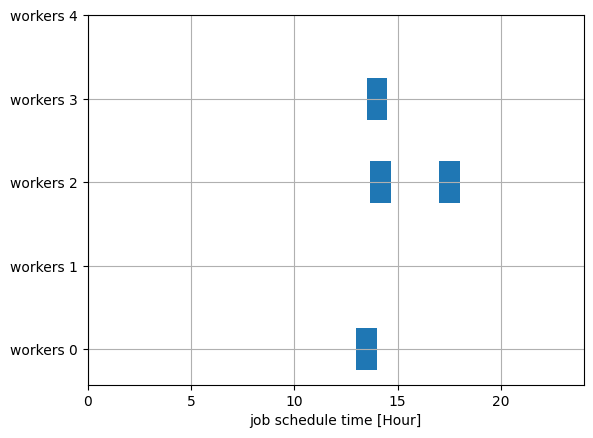

In [12]:
df = solution.decision_variables
solution_y = df[df["name"] == "y"]["value"].to_list()
solution_x = df[(df["name"] == "x") & (df["value"] == 1)]["subscripts"].to_list()
plot_sol(job_list, solution_y, solution_x)

上記の図の青い部分が割り当てられた仕事です。この図から今回のケースでは作業者 `0`, `2`, `3` だけ仕事をアサインすれば良いことがわかります。作業者 `0` の賃金は1, 作業者 `2` の賃金は3, 作業者 `3` の賃金は2なので、賃金の合計は6になります。確かに賃金の合計が最小値となる割り当て方になっています。

## 別の場合

最後に、全ての仕事に重なりがある場合を解いてみましょう。

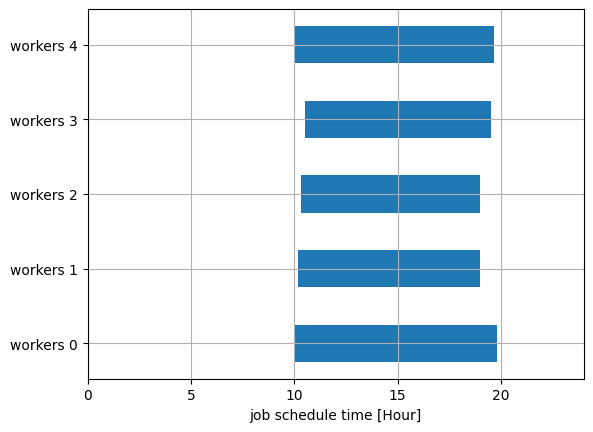

In [13]:
workers_costs = [1, 4, 3, 2, 5]
job_list = [
        (time(10, 10), time(19, 0)),
        (time(10, 20), time(19, 0)),
        (time(10, 30), time(19, 30)),
        (time(10, 0), time(19, 40)),
        (time(10, 0), time(19, 50)),
    ]

# Pre-process to job_list
g = gen_index_graph(job_list)
job_cliques = []
for c in nx.find_cliques(g):
    job_cliques.append(list(set(c)))

instance_data = {
            "W": len(workers_costs),
            "J": len(job_list),
            "b": workers_costs,
            "C": job_cliques,
            "Nc": len(job_cliques),
        }


interpreter = jm.Interpreter(instance_data)
instance = interpreter.eval_problem(problem)
solution = jijsolver.solve(instance, time_limit_sec=1.0)
df = solution.decision_variables
solution_y = df[df["name"] == "y"]["value"].to_list()
solution_x = df[(df["name"] == "x") & (df["value"] == 1)]["subscripts"].to_list()
plot_sol(job_list, solution_y, solution_x)

この場合、すべて作業者が仕事を行う必要があります。